In [1]:
import networkx as nx
from scipy.sparse import linalg as scp_sla
import numpy as np
import matplotlib.pyplot as plt

import sim_lib.graph as graph
import sim_lib.graph_create as gc
import sim_lib.graph_networkx as gnx
import sim_lib.util as util
import sim_lib.attr_lib.util as attr_util
from sim_lib.attr_lib.formation import *
import sim_lib.attr_lib.vis as vis

In [2]:
_N = 32

params = {
    'context_count' : 16,
    'k' : 8,
    'attr_func' : attr_util.discrete_pareto_val, # attribute assignment function
    'edge_util_func' : attr_util.total_inv_frequency,
    'edge_prob_func' : attr_util.logistic,
    'edge_selection' : attr_util.greedy_simul_edge_calc,
    'direct_cost' : 20,
    'indirect_cost' : 0
}

In [3]:
def graph_density(G):
    denum = (G.num_people * (G.num_people - 1))
    num = sum([ v.degree for v in G.vertices])
    return num / denum

def second_eigv(G):
    G_nx = gnx.graph_to_nx(G)
    laplacian = nx.linalg.laplacianmatrix.normalized_laplacian_matrix(G_nx)
    eigvals = scp_sla.eigs(laplacian, return_eigenvectors=False)
    eigvals.sort()
    return eigvals[1]

def apl(G):
    G_nx = gnx.graph_to_nx(G)
    return nx.average_shortest_path_length(G_nx)

def diam(G):
    G_nx = gnx.graph_to_nx(G)
    return nx.diameter(G_nx)

def social_welfare(G):
    return sum([ v.data for v in G.vertices ]) / 2

In [4]:
def plot_distributions(G):
    
    # Degree distribution
    degree_dist = [ v.degree for v in G.vertices ]
    norm_degree_dist = [ d / max(degree_dist) for d in degree_dist ]
    
    G_nx = gnx.graph_to_nx(G)
    eigv_centralities = nx.eigenvector_centrality(G_nx, weight='util')
    eigv_centralities = list(eigv_centralities.values())
    
    metric_dists = [norm_degree_dist, eigv_centralities]
    dist_labels = ['norm degree', 'eigenvector cent']
    
    bins = np.linspace(0, 1, 100)
    plt.hist(metric_dists, bins, alpha=0.5, label=dist_labels)
    plt.legend(loc='upper right')
    plt.show()
    

In [5]:
def print_metrics(G):
    gd = graph_density(G)
    eig2 = second_eigv(G)
    sw = social_welfare(G)
    try:
        avg_pl = apl(G)
    except:
        avg_pl = -1
    try:
        diameter = diam(G)
    except:
        diameter = -1
    
    print("""Graph density: {0}, \n
    average path length: {1}, \n
    diameter: {2}, \n
    second eigenvalue: {3}, \n
    social welfare: {4} \n""".format(gd, avg_pl, diameter, eig2, sw))

Graph density: 0.18346774193548387, 

    average path length: 2.1169354838709675, 

    diameter: 4, 

    second eigenvalue: (1.498421099904616+0j), 

    social welfare: 887.289998889999 



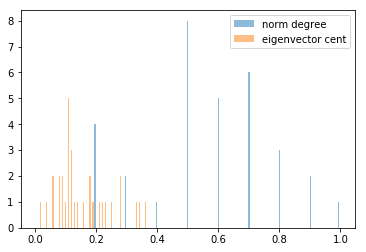

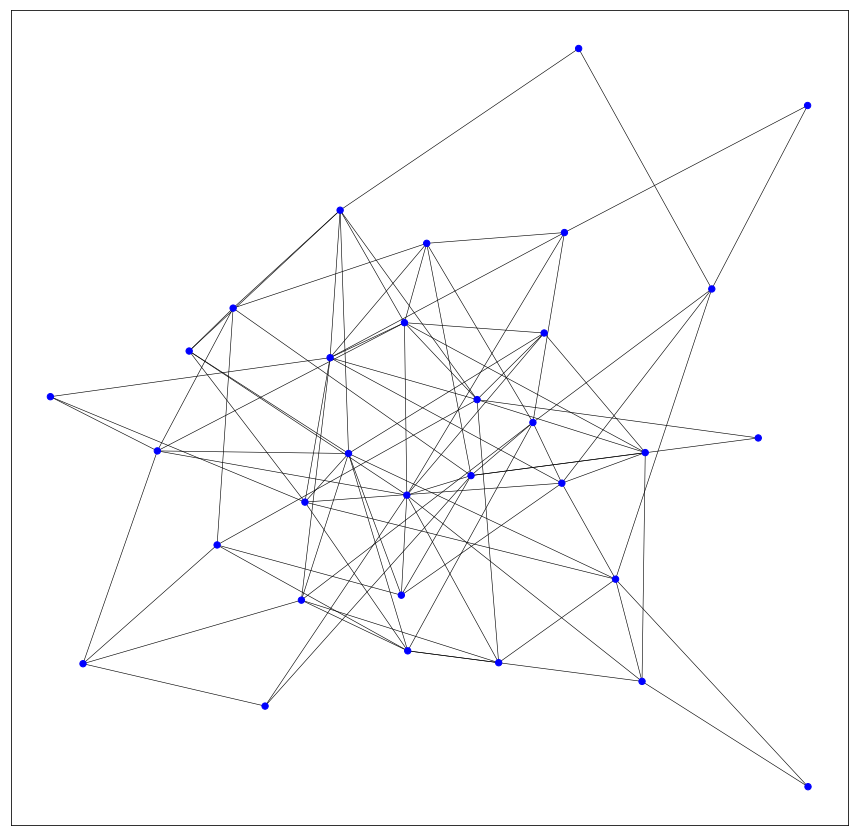

Graph density: 0.25806451612903225, 

    average path length: 1.8004032258064515, 

    diameter: 3, 

    second eigenvalue: (1.428113176429926+0j), 

    social welfare: 1805.4358277429487 



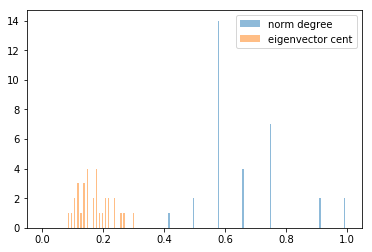

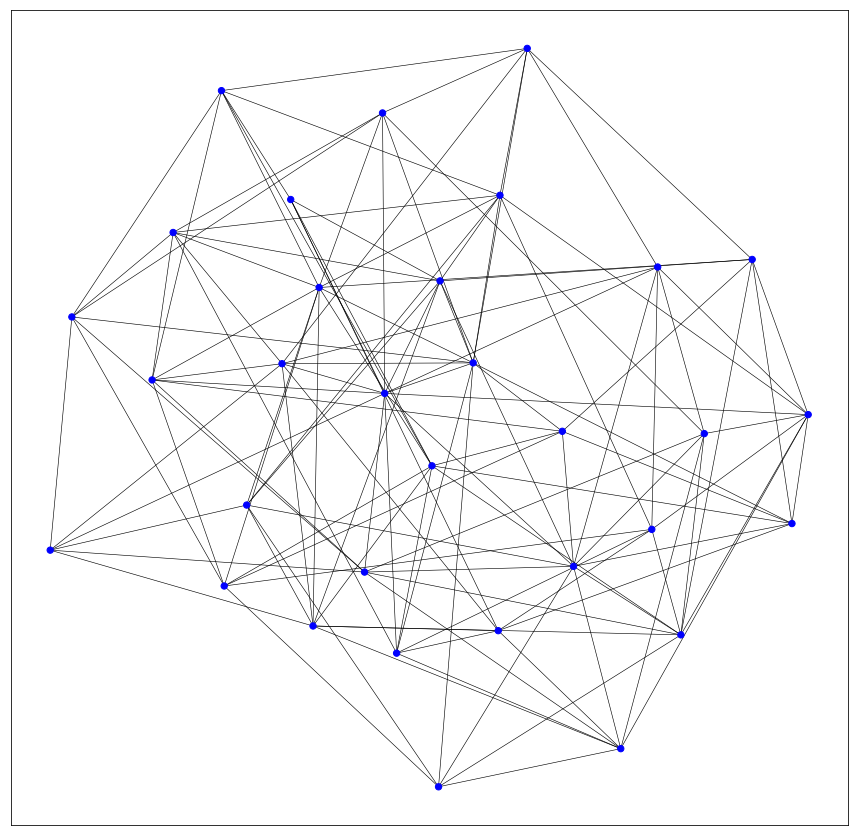

In [6]:
G = attribute_network(_N, params)

print_metrics(G)
plot_distributions(G)
vis.draw_graph(G)

random_walk(G)
calc_utils(G)
calc_edges(G)

print_metrics(G)
plot_distributions(G)
        
#print(list(zip([ v.vnum for v in G.vertices], 
#               [ attr_util.remaining_budget(v, G) for v in G.vertices ],
#               [ v.degree for v in G.vertices ])))

vis.draw_graph(G)